# A AR(1) + GARCH(1,1) Model

In [1]:
using Optim, PyPlot

import Formatting
include("jlFiles/printmat.jl")

printmat (generic function with 5 methods)

In [2]:
xx   = readdlm("Data/FFdSizePs.csv",',',header=true)
x    = xx[1]
ymd  = x[:,1]     #[YearMonthDay]
y    = x[:,2]     #returns for the size portfolio we want to study

yx = [y[2:end] y[1:end-1] ones(size(y,1)-1,1)]     #y(t),y(t-1),1
y  = yx[:,1]
x  = yx[:,2:3]

8324×2 Array{Float64,2}:
 -1.18  1.0
 -1.37  1.0
  1.73  1.0
  0.77  1.0
  1.41  1.0
  0.68  1.0
  1.26  1.0
  0.61  1.0
  1.11  1.0
  0.63  1.0
  0.64  1.0
  0.37  1.0
  0.49  1.0
  ⋮        
 -0.52  1.0
 -0.3   1.0
  0.18  1.0
  1.13  1.0
  1.11  1.0
 -0.11  1.0
  0.58  1.0
 -0.53  1.0
 -0.57  1.0
 -0.45  1.0
 -0.35  1.0
 -0.34  1.0

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$$
\begin{align*}
y_{t}           &  =x_{t}^{\prime}b+u_{t}\text{ with }u_{t}=v_{t}\sigma_{t}\\
\sigma_{t}^{2}  &  =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
\end{align*}
$$

If $v_{t}\sim N(0,1)$, then the likelihood function is

$$
\ln\mathcal{L}=-\frac{T}{2}\ln\left(  2\pi\right)  -\frac{1}{2}\sum_{t=1}
^{T}\ln\sigma_{t}^{2}-\frac{1}{2}\sum_{t=1}^{T}\frac{u_{t}^{2}}{\sigma_{t}
^{2}}.
$$


The likelihood function of a GARCH(1,1) model can be coded as in
*garch11LL*. The first function calculates time-varying  variances and
the likelihood contributions (for each period). The second functions forms the
loss function used in the minimization.


In [3]:
function garch11LL(parm::Vector,yx)

  y = yx[:,1]               #split up yx
  x = yx[:,2:end]
  T = size(x,1)
  k = size(x,2)

  b     = parm[1:k]         #mean equation, y = x'*b
  omega = abs(parm[k+1])    #GARCH(1,1) equation: s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)
  alpha = abs(parm[k+2])
  beta1 = abs(parm[k+3])    #do not use label 'beta' since that is a jl function

  yhat = x*b
  u    = y - yhat
  s2_0 = var(u)                                 #var(u,1) gives a matrix, var(u) a scalar

  s2    = fill(NaN,T)
  s2[1] = omega + alpha*s2_0 + beta1*s2_0        #simple, but slow apparoach
  for t = 2:T                                    #using filter() is perhaps quicker
    s2[t] = omega + alpha*u[t-1]^2 + beta1*s2[t-1]
  end

  LL    = -(1/2)*log(2*pi) - (1/2)*log.(s2) - (1/2)*(u.^2)./s2
  LL[1] = 0               #effectively skip the first observation

                          #output scalar: overall LL function value
  LL = -sum(LL)           #to minimize -sum(LL), notice

  return LL,s2,yhat

end


function garch11LLLoss(parm::Vector,yx)
  LL, = garch11LL(parm::Vector,yx)
  return LL
end

garch11LLLoss (generic function with 1 method)

## Maximize the Likelihood Function

In [4]:
#mean equation, y = x'b
#GARCH(1,1) equation: s2(t) = alfa0 + alfa1*u(t-1)^2 + beta1*s2(t-1)

par0 = [0;mean(y,1);(var(y,1)/5);0.1;0.6]        #initial parameter guess

(loglik,s2,yhat) = garch11LL(par0,yx)            #just testing the log lik
LL               = garch11LLLoss(par0,yx)
println("Value of (-)log-likelihood fn at starting guess: $(round(LL,1))")

Sol = optimize(par->garch11LLLoss(par,yx),par0)   #do MLE by optimization with optimize, minimize -sum(LL)

parHat            = Optim.minimizer(Sol)          #extract the optimal solution 
parHat[end-2:end] = abs(parHat[end-2:end])        #since the likelihood function uses abs(these values)

LLHat             = garch11LLLoss(parHat,yx)
println("Value of (-)log-likelihood fn at estimate: $(round(LLHat,1))")

println("\nParameter estimates: ")
printmat(parHat)

Value of (-)log-likelihood fn at starting guess: 9373.2
Value of (-)log-likelihood fn at estimate: 8243.6

Parameter estimates: 
     0.256
     0.049
     0.014
     0.162
     0.824



## Value at Risk


Coverage ratio for VaR(95%): 0.059

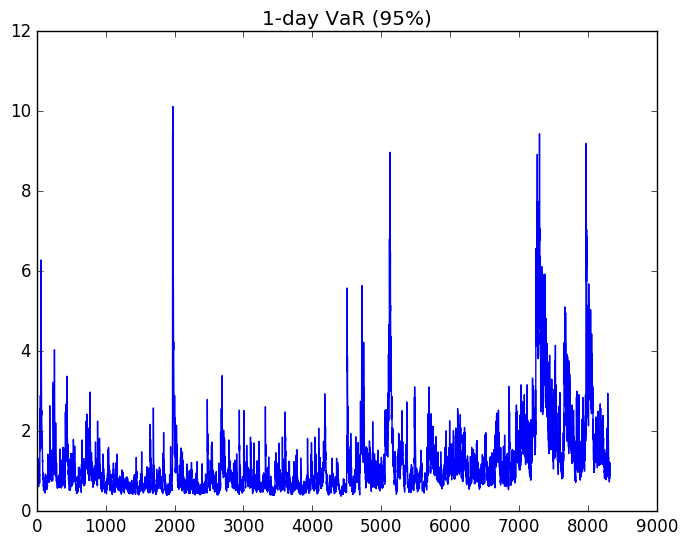

In [5]:
(loglik,s2,ER) = garch11LL(parHat,yx)
VaR95          = -(ER - 1.64*sqrt(s2))

figure()
  plot(VaR95)
title("1-day VaR (95%)")
show()

CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
println("\nCoverage ratio for VaR(95%): $(round(CovRatio,3))")